# Notebook 1 - Dados MRI

    -> Rodar rodada 3 do freesurfer nkienhanced
    -> Rodar rodada 4 do freesurfer nkipilot

## Ambiente

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from nilearn import surface
from matplotlib import pyplot as plt
import time

/home/brunovieira/.conda/envs/tamires/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
pd.set_option('display.max_rows', 500)

## Dados

In [3]:
nkienhanced = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/nkienhanced/"  
drops = ['dataset_description.json','derivatives','README',
         'task-CHECKERBOARD_acq-1400_bold.json',
         'task-CHECKERBOARD_acq-645_bold.json',
         'task-DMNTRACKINGTRAIN_bold.json',
         'task-MSIT_bold.json',
         'task-PEER2_bold.json',
         'task-rest_acq-1400_bold.json',
         'task-rest_acq-645_bold.json',
         'task-rest_pcasl.json',
         'CHANGES',
         'participants.tsv',
         'task-BREATHHOLD_acq-1400_bold.json',
         'task-DMNTRACKINGTEST_bold.json',
         'task-MORALDILEMMA_bold.json',
         'task-PEER1_bold.json',
         'task-rest_acq-CAP_bold.json']

dir_list = [a[4:] for a in os.listdir(nkienhanced) if a not in drops]
len(dir_list) # deveria ser 929 

929

In [4]:
nkipilot = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/nkipilot/"
len(os.listdir(nkipilot)) - 2 # deveria ser 200

211

In [5]:
# Participants Infos
participants_nkienhanced = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/participants_nkienhanced.tsv"
participants_nkipilot = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/participants_nkipilot.tsv"

# Freesurfer Outputs
freesurfer_data_folder = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/nki_data/"

# Logs
logs_folder = "/home/brunovieira/Tamires_Experiments/Outputs/Logs/"

# Base final MRI
path_base_mri = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/"

## Acessando Processamento FreeSurfer  

In [6]:
#usando os dados padrao do individuo A00008326
path = "/home/brunovieira/Tamires_Experiments/Bases_de_Dados/nki_data/A00008326/"

#acessando o dicionario de estruturas e seus codigos
b = "label/aparc.annot.DKTatlas.ctab"
x = pd.read_csv(path+b , header=None, delimiter=r"\s+")
x = x[[0,1]]
x = x.set_index([1])

#acessando os dados de estatistica de cada estrutura de um sujeito
a = path + "stats/rh.aparc.DKTatlas.stats"
columns = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
y = pd.read_csv(a , delimiter=r"\s+", skiprows=59, header=0, names=columns, index_col=False)
y = y.set_index(['StructName'])

#adicionando o codigo das estruturas
z = pd.concat([x,y],join="inner",axis=1).reset_index()
z = z.rename(columns = {'index':'StructName',0:'StructCode'})
z2 = z.drop(columns=['StructName','StructCode'])

#criando nome das colunas do dataframe final : hemisferio x columns x StructCode
feature_stats = []
for j in z.StructCode:
    for i in list(z2.columns):
        feature_stats.append(str(j)+'_'+i)
feature_stats = ['hemisphere']+feature_stats

#criando df final
df_struct_stats = pd.DataFrame(columns=feature_stats)

def struct_stats(participant, hemisphere):
    
    #acessando os dados de estatistica de cada estrutura de um sujeito
    a = freesurfer_data_folder+participant+"/stats/"+str(hemisphere)+".aparc.DKTatlas.stats"
    columns = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
    y = pd.read_csv(a , delimiter=r"\s+", skiprows=59, header=0, names=columns, index_col=False)
    y = y.set_index(['StructName'])

    #adicionando o codigo das estruturas
    z = pd.concat([x,y],join="inner",axis=1).reset_index()
    z = z.rename(columns = {'index':'StructName',0:'StructCode'})
    z2 = z.drop(columns=['StructName','StructCode'])

    #transformando em um vetor o dataframe stats
    part_stats = z2.to_numpy().flatten()
    
    #add dataframe final
    df_struct_stats.loc[participant+hemisphere] = [hemisphere]+list(part_stats)

/home/brunovieira/.conda/envs/tamires/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [7]:
participants_list = os.listdir(freesurfer_data_folder)
participants_list = np.setdiff1d(participants_list, ['fsaverage'])

data = []
participants_list_completed = []
participants_list_incompleted = []
t=0
for participant in participants_list:
    #t = t+1
    #print(t)
    
    feature_processed = []
    for hemisphere in ['lh', 'rh']:

        atlasEcono = "/label/"+str(hemisphere)+".Eco.annot" 
        atlasDF = "/label/"+str(hemisphere)+".aparc.DKTatlas.annot" # o atlas padrao do fastsurfer é lh.aparc.mapped.annot 
        area = "/surf/"+str(hemisphere)+".area"
        curv = "/surf/"+str(hemisphere)+".curv"
        sulc = "/surf/"+str(hemisphere)+".sulc"
        thickness = "/surf/"+str(hemisphere)+".thickness"

        features = [atlasEcono, atlasDF, area, curv, sulc, thickness]
    
        for feature in features:
            try:
                feature_processed.append(surface.load_surf_data(freesurfer_data_folder + participant + feature))
            except:
                #print('Error: '+str(participant)+' has no '+feature)
                participants_list_incompleted.append(participant)
                pass
        try:
            struct_stats(participant, hemisphere)
        except:
            #participants_list_incompleted.append(participant)
            pass
        
    data.append([participant, feature_processed])

participants_list_incompleted = np.unique(participants_list_incompleted)
participants_list_comp = [[i, sub] for i, sub in enumerate(participants_list) if sub not in participants_list_incompleted]
participants_list_completed_index = pd.DataFrame(participants_list_comp)[0]
participants_list_completed = pd.DataFrame(participants_list_comp)[1] 

print('Number of Participants with Folders:'+str(len(participants_list)))
print('Number of Participants Incompleted:'+str(len(participants_list_incompleted)))
print('Number of Participants Completed:'+str(len(participants_list_completed)))
#df_struct_stats.to_csv(path_base_mri + "MRI_Data_Areas_" + str(round(len(df_struct_stats)/2)) + ".csv")

Number of Participants with Folders:929
Number of Participants Incompleted:35
Number of Participants Completed:894


In [8]:
participants_list_incompleted

array(['A00013809', 'A00028177', 'A00031411', 'A00031578', 'A00035869',
       'A00038424', 'A00039218', 'A00040798', 'A00052307', 'A00053203',
       'A00054153', 'A00054578', 'A00055727', 'A00055765', 'A00055907',
       'A00055921', 'A00056022', 'A00056746', 'A00057809', 'A00057863',
       'A00058516', 'A00059733', 'A00059734', 'A00060493', 'A00060675',
       'A00062085', 'A00062349', 'A00063425', 'A00064418', 'A00064597',
       'A00065262', 'A00065820', 'A00066534', 'A00066573', 'A00066581'],
      dtype='<U9')

## Analisando tempo de processamento 

In [21]:
table = []
for file in os.listdir(logs_folder):
    if file[:4] == "mpi_":
        job = file[4:10]
        print(job)
        
        # tempo de processamento
        os.environ["job"] = str(job)
        time = !sacct -j $job --format=Elapsed
        time_start = time[2][2:10]
        try:
            time_end = time[3][2:10]
            time_end_h = int(pd.to_datetime(time_end, format="%H:%M:%S").hour)
        except:
            time_end = np.nan
            time_end_h = np.nan
        
        try:
            # numero do sujeito
            with open(logs_folder+file, "r") as f:
                lines = f.readlines()
                sub = lines[1][81:90]    

            # definição de status
            if sub not in list(participants_list):
                about_to_start = 1 #ja tem log mas ainda nao tem pasta  
                completed = 0
                interrupted = 0
                processing = 0
            else:
                about_to_start = 0 #ja tem log e tem pasta 

                if sub in list(participants_list_completed):
                    completed = 1
                    interrupted = 0
                    processing = 0
                else:
                    completed = 0           
                    if np.isnan(time_end_h):
                        interrupted = 0
                        processing = 1
                    else:
                        interrupted = 1
                        processing = 0

            table.append([job, sub, time_start, time_end, time_end_h, about_to_start, processing, interrupted, completed])
        
        except:
            print('Error: '+str(file))

               

662964
662965
662966
662967
662968
662969
662970
662971
662972
662973
662974
662975
662976
662977
662978
662979
662980
662981
662982
662983
662984
662985
662986
662987
662988
662989
662990
662991
662992
662993
662994
662995
662996
662997
662998
662999
663000
663001
663002
663003
663004
663005
663006
663007
663008
663009
663010
663011
663012
663013
663014
663015
663016
663017
663018
663019
663020
663021
663022
663023
663024
663025
663026
663027
663028
663029
663030
663031
663032
663033
663034
663035
663036
663037
663038
663039
663040
663041
663042
663043
663044
663045
663046
663047
663048
663049
663050
663051
663052
663053
663054
663055
663056
663057
663058
663059
663060
663061
663062
663063
663064
663065
663066
663067
663068
663069
663070
663071
663072
663073
663074
663075
663076
663077
663078
663079
663080
663081
663082
663083
663084
663085
663086
663087
663088
663089
663090
663091
663092
663093
663094
663095
663096
663097
663098
663099
663100
663101
663102
663103
663104
663105
663106

664147
664148
664149
664150
664151
664152
664153
664154
664155
664156
664157
664158
664159
664160
664161
664162
664163
664164
664165
664166
664167
664168
664169
664170
664171
664172
664173
664174
664175
664176
664177
664178
664179
664405
664403
664404
664406
664407
664408
664410
664409
664411
664413
664419
664421
664412
664420
664414
664415
664416
664417
664422
664437
664418
664435
664423
664436
664453
664424
664451
664439
664425
664452
664438
664440
664442
664441
664443
664445
664444
664446
664447
664448
664450
664449
664426
664427
664428
664429
664430
664432
664431
664433
664434
664454
664455
664457
664456
664458
664459
664461
664460
664462
664463
664467
664468
664464
664469
664470
664471
664465
664492
664472
664487
664466
664473
664489
664474
664488
664475
664476
664491
664477
664493
664490
664478
664479
664480
664481
664482
664483
664484
664485
664486
664495
664498
664497
664496
664499
664500
664502
664501
664494
664504
664505
664510
664503
664513
664511
664512
664506
664515
664508

In [22]:
table = pd.DataFrame(table, columns=['Job_id', 'Sub_id', 'Time_processing', 'Time_end', 'Time_end_hour', 
                                     'About_to_start', 'Processing', 'Interrupted', 'Completed'])
table['sum_status'] = table.About_to_start + table.Processing + table.Interrupted + table.Completed
table.head() 

,Job_id,Sub_id,Time_processing,Time_end,Time_end_hour,About_to_start,Processing,Interrupted,Completed,sum_status
0,662964,/brunovie,00:00:00,00:00:00,0,1,0,0,0,1
1,662965,A00008326,06:52:07,06:52:07,6,0,0,0,1,1
2,662966,A00008399,13:52:18,13:52:18,13,0,0,0,1,1
3,662967,A00010893,11:04:29,11:04:29,11,0,0,0,1,1
4,662968,A00013809,00:01:55,00:01:55,0,0,0,1,0,1


In [23]:
table[(table.About_to_start==1)]

,Job_id,Sub_id,Time_processing,Time_end,Time_end_hour,About_to_start,Processing,Interrupted,Completed,sum_status
0,662964,/brunovie,00:00:00,00:00:00,0,1,0,0,0,1
1204,664405,s/Bases_d,12:44:43,12:44:43,12,1,0,0,0,1
1205,664403,s/Bases_d,20:00:14,20:00:14,20,1,0,0,0,1
1206,664404,s/Bases_d,12:30:23,12:30:23,12,1,0,0,0,1
1207,664406,s/Bases_d,13:07:40,13:07:40,13,1,0,0,0,1
1208,664407,s/Bases_d,14:31:56,14:31:56,14,1,0,0,0,1
1209,664408,s/Bases_d,11:59:09,11:59:09,11,1,0,0,0,1
1210,664410,s/Bases_d,00:01:34,00:01:34,0,1,0,0,0,1
1211,664409,s/Bases_d,11:46:44,11:46:44,11,1,0,0,0,1
1212,664411,s/Bases_d,10:38:13,10:38:13,10,1,0,0,0,1


In [24]:
dup_com = len(table.Sub_id[table.Completed==1]) - len(table.Sub_id[table.Completed==1].unique())
dup_int = len(table.Sub_id[table.Interrupted==1]) - len(table.Sub_id[table.Interrupted==1].unique())
dup_abo = len(table.Sub_id[table.About_to_start==1]) - len(table.Sub_id[table.About_to_start==1].unique())
dup_pro = len(table.Sub_id[table.Processing==1]) - len(table.Sub_id[table.Processing==1].unique())
    
print('Number of Participants About to start: '+str(sum(table.About_to_start)-dup_abo))
print('Number of Participants About to start Duplicated: '+str(dup_abo))

print('Number of Participants Processing: '+str(sum(table.Processing)-dup_pro))
print('Number of Participants Processing Duplicated: '+str(dup_pro))

print('Number of Participants Interrupted: '+str(sum(table.Interrupted)-dup_int))
print('Number of Participants Interrupted Duplicated: '+str(dup_int))

print('Number of Participants Completed: '+str(sum(table.Completed)-dup_com))
print('Number of Participants Completed Duplicated: '+str(dup_com))

log_list = list(table.Sub_id.unique())[1:]
print('Total log list: '+str(len(log_list)))

not_started = [a for a in dir_list if a not in log_list]
print('Number of Participants Without log or folder: '+str(len(not_started)))

Number of Participants About to start: 4
Number of Participants About to start Duplicated: 409
Number of Participants Processing: 0
Number of Participants Processing Duplicated: 0
Number of Participants Interrupted: 35
Number of Participants Interrupted Duplicated: 7
Number of Participants Completed: 894
Number of Participants Completed Duplicated: 267
Total log list: 932
Number of Participants Without log or folder: 0


#### Registro 14/02 11:00
- Number of Participants Duplicated: 274
- Number of Participants About to start or Processing: 213
- Number of Participants Interrupted: 196
- Number of Participants Completed: 521
- Total log list: 929
- Number of Participants Without log or folder: 0

In [12]:
table.describe()

,Time_end_hour,About_to_start,Processing,Interrupted,Completed,sum_status
count,1611.000000,1616.000000,1616.0,1616.000000,1616.000000,1616.0
mean,9.074488,0.255569,0.0,0.026609,0.717822,1.0
std,4.956272,0.436316,0.0,0.160987,0.450199,0.0
min,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,8.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,10.000000,0.000000,0.0,0.000000,1.000000,1.0
75%,12.000000,1.000000,0.0,0.000000,1.000000,1.0
max,23.000000,1.000000,0.0,1.000000,1.000000,1.0


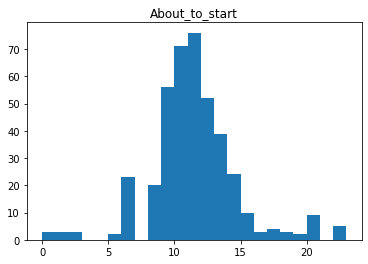

408


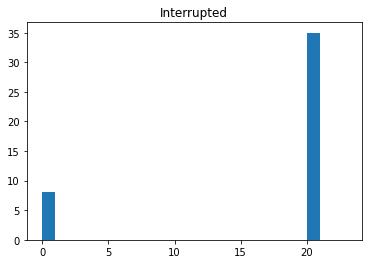

43


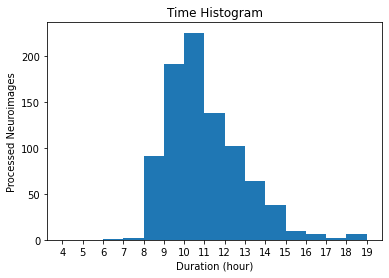

1160


In [13]:
bins = range(0,24,1)

time_end_hour1 = table[table.About_to_start==1].Time_end_hour.dropna()
plt.hist(time_end_hour1,bins)
plt.title('About_to_start')
plt.show()
print(len(time_end_hour1))

time_end_hour2 = table[table.Interrupted==1].Time_end_hour.dropna()
plt.hist(time_end_hour2,bins)
plt.title('Interrupted')
plt.show()
print(len(time_end_hour2))

time_end_hour = table[table.Completed==1].Time_end_hour.dropna()
plt.hist(time_end_hour[time_end_hour !=0],bins=range(4, 20, 1))
plt.title('Time Histogram')
plt.xticks(range(4, 20, 1))
plt.xlabel('Duration (hour)')
plt.ylabel('Processed Neuroimages')
plt.show()
print(len(time_end_hour))

267


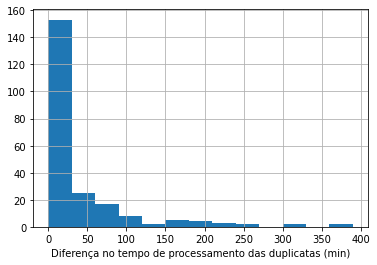

In [219]:
sub_dupli = table[table.Completed==1].groupby('Sub_id').sum()
sub_dupli = list(sub_dupli[sub_dupli.Completed==2].index)
b = table[table.Sub_id.isin(sub_dupli)].sort_values('Sub_id').reset_index(drop=True)

div = []
for i in range(0,int(len(b)/2)):
    dupla = [b.loc[i].Time_processing, b.loc[i+1].Time_end]
    dupla.sort()
    div.append(dupla)
div = pd.DataFrame(div,columns=['x','y'])

div.x = div.x.apply(pd.to_timedelta)
div.y = div.y.apply(pd.to_timedelta)
difference = (div.y-div.x)#.hour

(difference / pd.Timedelta(minutes=1)).hist(bins=range(0, 400, 30))
plt.xlabel('Diferença no tempo de processamento das duplicatas (min)')
print(len(difference))

## Limpando arquivos com erro

In [163]:
# dropar interrompidos/corrompidos
#drops_14_fev = list(table[(table.Interrupted ==1) | (table.About_to_start==1)].Sub_id) 
#pd.Series(drops_14_fev).to_csv(path_base_mri +'/subs_error_14_fev.csv')
#len(drops_14_fev)

In [162]:
# deletando pastas incompletas
#for participant in drops[1:]:
 #   try:
  #      shutil.rmtree(freesurfer_data_folder + participant)
   #     print('Done: '+str(participant)+' was deleted ')
    #except:
     #   print('Error: '+str(participant)+' was not deleted ')

In [165]:
# rescrevendo arquivo de sujeitos processados
#with open('/home/brunovieira/Tamires_Experiments/Scripts/ImageProcessing/processed_subjects.txt', 'w') as f:
 #   for item in participants_list:
  #      f.write("%s\n" % item)
#print('-> Processed subjects file alterado')

## Criando Base de Dados MRI

In [9]:
nkienhanced_infos = pd.read_csv(participants_nkienhanced, sep='\t', header=0)
nkienhanced_infos = nkienhanced_infos.rename(columns={'participant_id': "participant"})
nkienhanced_infos.set_index('participant',inplace=True)
nkienhanced_infos

,age,sex,handedness
participant,,,
A00028185,26.0,MALE,RIGHT
A00028352,23.0,FEMALE,RIGHT
A00032875,37.0,FEMALE,LEFT
A00033747,26.0,FEMALE,RIGHT
A00034854,21.0,FEMALE,RIGHT
...,...,...,...
A00073705,78.0,FEMALE,RIGHT
A00073942,62.0,FEMALE,RIGHT
A00073953,69.0,FEMALE,RIGHT


(array([ 94.,  99.,  79., 113.,  60.,  37.,  38.,  56.,  61.,  57.,  62.,
         47.,  54.,  38.,  20.,  14.]),
 array([ 6.    , 10.9375, 15.875 , 20.8125, 25.75  , 30.6875, 35.625 ,
        40.5625, 45.5   , 50.4375, 55.375 , 60.3125, 65.25  , 70.1875,
        75.125 , 80.0625, 85.    ]),
 <BarContainer object of 16 artists>)

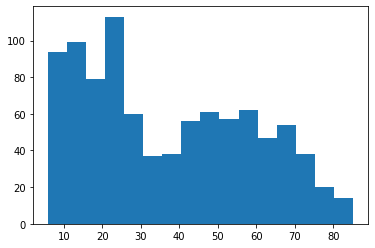

In [10]:
plt.hist(nkienhanced_infos.age, bins=16)

In [11]:
len(nkienhanced_infos.age[nkienhanced_infos.age>70])

72

In [12]:
df_dict = {"participant":[],"hemisphere":[],"atlasEcono":[],"atlasDF":[], "area":[],"curv":[],"sulc":[],"thickness":[]}
participants_list_completed_index = list(participants_list_completed_index)

for i,part in enumerate(data):
    if i in participants_list_completed_index:
        print(i)
        
        frame_lh = np.array(part[1][0:6])

        df_dict['atlasEcono'].extend(frame_lh[0])  
        df_dict['atlasDF'].extend(frame_lh[1])
        df_dict['area'].extend(frame_lh[2])
        df_dict['curv'].extend(frame_lh[3])
        df_dict['sulc'].extend(frame_lh[4])
        df_dict['thickness'].extend(frame_lh[5])
        df_dict['participant'].extend([part[0]] * len(frame_lh[0]))
        df_dict['hemisphere'].extend(['left'] * len(frame_lh[0]))
        
        
        frame_rh = np.array(part[1][6:12])
        df_dict['atlasEcono'].extend(frame_rh[0])
        df_dict['atlasDF'].extend(frame_rh[1])
        df_dict['area'].extend(frame_rh[2])
        df_dict['curv'].extend(frame_rh[3])
        df_dict['sulc'].extend(frame_rh[4])
        df_dict['thickness'].extend(frame_rh[5])
        df_dict['participant'].extend([part[0]] * len(frame_rh[0]))
        df_dict['hemisphere'].extend(['right'] * len(frame_rh[0]))
        


0
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
87
88
89
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
2

In [43]:
dataframe = pd.DataFrame(df_dict)        
final = dataframe.merge(nkienhanced_infos, left_on='participant', right_on='participant')
final

,participant,hemisphere,atlasEcono,atlasDF,area,curv,sulc,thickness,age,sex,handedness
0,A00008326,left,27.0,11.0,0.482277,-0.068565,-4.607964,2.404729,59.0,FEMALE,RIGHT
1,A00008326,left,27.0,11.0,0.582267,-0.071342,-4.497762,2.637928,59.0,FEMALE,RIGHT
2,A00008326,left,27.0,11.0,0.635383,-0.099074,-4.450983,2.640083,59.0,FEMALE,RIGHT
3,A00008326,left,27.0,11.0,0.206755,-0.128096,-4.490544,2.556666,59.0,FEMALE,RIGHT
4,A00008326,left,27.0,11.0,0.330194,-0.153142,-4.453268,2.495451,59.0,FEMALE,RIGHT
...,...,...,...,...,...,...,...,...,...,...,...
238290853,A00074034,right,6.0,28.0,1.568519,-0.360558,-6.311138,3.693176,10.0,FEMALE,RIGHT
238290854,A00074034,right,6.0,28.0,0.625350,-0.421964,-8.502458,3.543430,10.0,FEMALE,RIGHT
238290855,A00074034,right,6.0,28.0,1.527038,-0.354660,-8.860283,3.792696,10.0,FEMALE,RIGHT
238290856,A00074034,right,6.0,28.0,0.938139,-0.399875,-7.467211,4.126412,10.0,FEMALE,RIGHT


In [42]:
final.to_parquet(path_base_mri + "MRI_Data_Voxels_" + str(len(final.participant.unique())) + ".parquet")